In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
N = len(num_spk)

In [66]:
class SpikeVec:
    def __init__(self, tag):
        pass
    
    def read(self, tag):
        pass

with open("./spike_info.txt", "r") as fid:
    num_spk = np.array([int(i) for i in fid.readline().split(",")[:-1]])
    
step_spk = []
with open("./spike.dat", "rb") as fid:
    tmp = np.fromfile(fid, dtype=np.int32)
    n0 = 0
    for n in range(N):
        step_spk.append(tmp[n0:n0+num_spk[n]])
        n0 += num_spk[n]
        

fs = 2000 ## -> 나중에 이것도 select 필요
def read_data(fname, N=100):
    with open(fname, "rb") as fp:
        data = np.fromfile(fp, dtype=np.float32).reshape([-1, N])
    t = np.arange(data.shape[0]) / fs
    return data, t

N = 100
vs, t = read_data("./check_v.dat", N)
re, t = read_data("./check_syn_e.dat", N)
ri, t = read_data("./check_syn_i.dat", N)
rext, t = read_data("./check_syn_ext.dat", N)


with open("./check_v0.txt", "r") as fp:
    v0 = np.array([float(x) for x in fp.readline().split(",")[:-1]])
    t0 = np.arange(len(v0)) * 0.001 / 1000

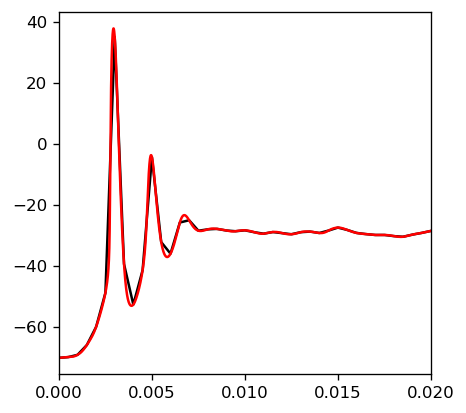

In [71]:
plt.figure(dpi=120, figsize=(4,4))
plt.plot(t, vs[:, 0], 'k')
plt.plot(t0, v0, 'r')
plt.xlim([0, 0.02])
plt.show()

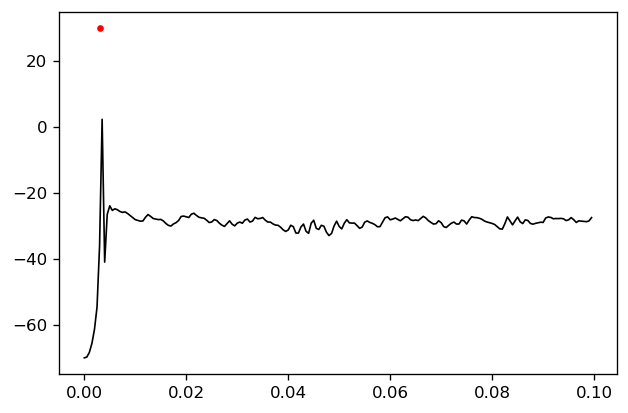

In [76]:
nid = 95
vth = 30
dt = 0.001

plt.figure(dpi=120, figsize=(6, 4))
plt.plot(t, vs[:, nid], c='k', lw=1)
plt.plot(step_spk[nid]*dt/1000, [vth] * len(step_spk[nid]), 'r.')
plt.show()

In [60]:
step_spk[nid]

array([2771], dtype=int32)

In [54]:
step_spk[0]

array([2771], dtype=int32)

In [ ]:
step_spk[n

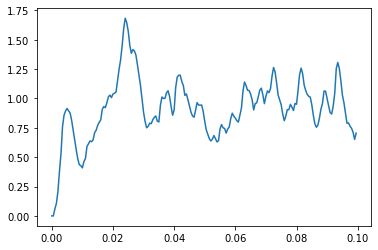

In [41]:
plt.plot(t, rext[:,3])

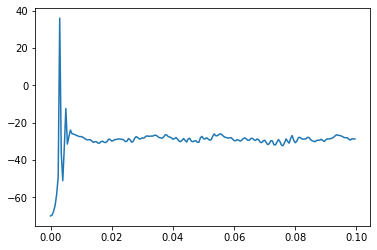

In [46]:
plt.plot(t, vs[:, 10])

In [20]:
tmp.sha

1

In [15]:
len(tmp)

764

In [13]:
np.sum(num_spk)

764

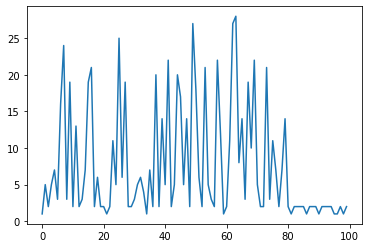

In [3]:
plt.plot(num_spk)